# Capstone 2. Data cleaning & storytelling

July, 2018
***


**Objective:** As I mentioned in the proposal, the major goal of this capstone project is to help job seekers, especially those new graduates with not previous job experience, find their dream job based on their answers to our questionnaire. Because extensive web scrap is perhibited in those major job posting website such as Linkedin and indeed, I chose an job description data set from Kaggle.com. Data source: [kaggle dataset](https://www.kaggle.com/PromptCloudHQ/us-jobs-on-monstercom)

Questionnaire will cover those aspects:
- Industry 
- Location
- Culture

Each aspect need the user a number indicating the level of the importance.

And finally, we will do a matching between job descriptions and the answer of the questionnaire.
***
*For example: *

I may answer the questionnaire in this way:

- Industry = art; artificial intelligence. Weight = 40%
- Location = big cities; eastern coast. Weight = 20%
- Culture = innovation; open. Weight = 40%

And I hope to get job recommendations from this project.

In [305]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from time import sleep
import math
import seaborn as sns
from scipy.spatial import distance

import nltk
from nltk.stem import PorterStemmer
import gensim
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')

# Section 1: The dataset

In [12]:
# import the dataset and see how it looks like
df = pd.read_csv('monster_com-job_sample 2.csv')

# some basic inforamtion
print('There are {:d} job decriptions in the dataset.'.format(df.shape[0]))
print('The jobs are located in those country: ', df.country_code.unique().item())
print('{:d} out of 22000 job descriptions are tagged with a salary'.format(22000-sum(df.salary.isnull())))

There are 22000 job decriptions in the dataset.
The jobs are located in those country:  US
3446 out of 22000 job descriptions are tagged with a salary


In [13]:
# drop columns that are not helpful for the following analysis
df = df.drop(df.columns[[0,1,2,3,4,7,10,11,12,13]],axis=1)
df.head()

,job_description,job_title,location,organization
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail


In this dataset, we kept those columns which would be useful in the following sections. 
 - The **job_description** and **job_title** will be used to match industry. 
 - **organization** will be used for finding the name of that company and the culture of it. 
 - **location**, will be used to calculate distance, as well as finding out if the job located at big or small city, with increasing or declining population and so on.

# Section 2: Location 

### Extract the location information: zip code, state, city
Notice that this dataset is not cleaned. The locations have different format so that we need to extract that information use some technology such as regular expression.


In [14]:
# extract zip code information from the location column
# extract state information from the location column
p = re.compile(r'(?<![A-Z])[A-Z]{2}(?![A-Z])')
for i, row in df.iterrows():
    # add the column zip code
    ls = []
    for char in row.location:
        if char.isdigit():
            ls.append(char)
    if len(ls) == 5:
        df.set_value(i,'zip_code', ''.join(ls))
    
    # add the column state
    str_location = row.location
   
    if len(str_location) < 100 and len(str_location) > 1:
        state = p.search(str_location)
        if state is not None:
            df.set_value(i, 'state', state.group())
            ls = str_location.split(',')
            df.set_value(i, 'city', ls[0])
df.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,NaN,NaN,NaN
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries,NaN,CA,Dixon
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail,NaN,PA,Camphill


### Dataset exploration 1: look at locations that have the biggest number of jobs

There are 19194 jobs that shows which City they located at.


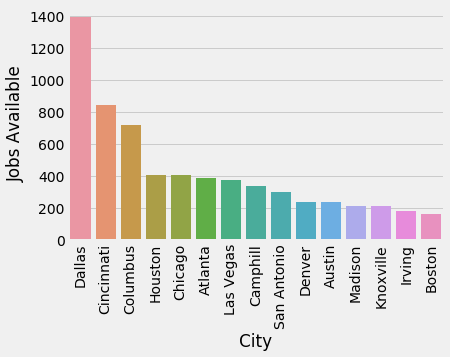

In [15]:
df_dropna = df[~df.state.isnull()]
print('There are %d jobs that shows which City they located at.' % len(df_dropna))

data = df_dropna.groupby('city').count().job_description.sort_values(ascending = False)[:15]
df_data = data.to_frame()
df_data['city'] = df_data.index
df_data.columns = ['Jobs Available', 'City']

g = sns.barplot(x='City', y='Jobs Available', data=df_data)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

There are 19194 jobs that shows which State they located at.


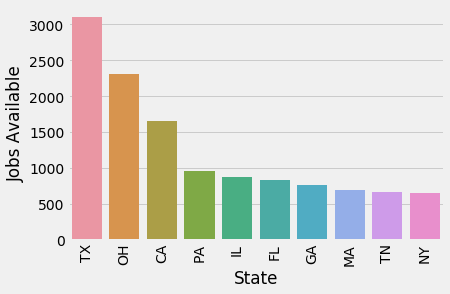

In [16]:
data = df_dropna.groupby('state').count().job_description.sort_values(ascending = False)[:10]
print('There are %d jobs that shows which State they located at.' % len(df_dropna))
df_data = data.to_frame()
df_data['State'] = df_data.index
df_data.columns = ['Jobs Available', 'State']

g = sns.barplot(x='State', y='Jobs Available', data=df_data)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Dataset exploration 2: save the DataFrame as excel and mapping the data in the USA map.

In [17]:
df_dropna_zip = df[~df.zip_code.isnull()]
print('There are %d jobs that shows which zip_code they located at.' % len(df_dropna_zip))

There are 12059 jobs that shows which zip_code they located at.


![map](map.png)

https://plot.ly/python/bubble-maps/

In [18]:
df_dropna_zip.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
7,RESPONSIBILITIES:Kforce has a client seeking a...,Mailroom Clerk Job in Austin,"Austin, TX 73301",NaN,73301,TX,Austin
8,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,78746,TX,Austin
10,Aflac Insurance Sales Agent While a career in ...,Aflac Insurance Sales Agent Job in Berryville,"Berryville, VA 22611",Insurance,22611,VA,Berryville


In [19]:
# this panda series contains the number of jobs in each zip code
data = df_dropna_zip.groupby('zip_code').count().job_description.sort_values(ascending = False)

In [20]:
import plotly as py
import plotly.figure_factory as ff
plotly.offline.init_notebook_mode(connected=True)

fips = ['06021', '06023', '06027',
        '06029', '06033', '06059',
        '06047', '06049', '06051',
        '06055', '06061']
values = range(len(fips))

fig = ff.create_choropleth(fips=fips, values=values)
py.offline.iplot(fig, filename='choropleth of some cali counties - full usa scope')

NameError: name 'plotly' is not defined

In [21]:
import plotly as py
import plotly.figure_factory as ff
plotly.offline.init_notebook_mode(connected=True)


fips = ['53702']
values = range(len(fips))

fig = ff.create_choropleth(fips=fips, values=values)
py.offline.iplot(fig, filename='choropleth of some cali counties - full usa scope')

NameError: name 'plotly' is not defined

### Determine the location index.
Location index is determined by the distance from where the job is and where the job seeker currently located. The index is also determined by the quality of the location. People may care different things about the location, such as the population, safety, near big city, near national park, city or country, art, education and so on. We can put all those factors in the questionnaire. This location index can be very complex and it would be impossible to complete in a short time. We'll simplify the calculation by picking 1 or 2 factors, like distance from home and population.


————note:
give a new map that shows the index of the locations. 

In [22]:
# calculate distance based on zip code
from pyzipcode import ZipCodeDatabase

zcdb = ZipCodeDatabase()
zipcode = zcdb[84112]
lan_home = zipcode.latitude
lon_home = zipcode.longitude

df_zip = df[df['zip_code'].notnull()]
df_zip = df_zip[~(df_zip['zip_code']=='00000')]

for i, row in df_zip.iterrows():
    #calculate distance
    try:
        zipcode = zcdb[row.zip_code]
        lan = zipcode.latitude
        lon = zipcode.longitude
        distance = math.sqrt((lan-lan_home)**2+(lon-lon_home)**2)
        df.set_value(i, 'distance_home', distance)
    except:
        pass

In [23]:
df_zip.shape

(12054, 7)

In [24]:
df_zip.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
7,RESPONSIBILITIES:Kforce has a client seeking a...,Mailroom Clerk Job in Austin,"Austin, TX 73301",NaN,73301,TX,Austin
8,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,78746,TX,Austin
10,Aflac Insurance Sales Agent While a career in ...,Aflac Insurance Sales Agent Job in Berryville,"Berryville, VA 22611",Insurance,22611,VA,Berryville


There are 12054 jobs in the dataset that has the distance information calcuated from zip code.

Population is an important aspect when investigating a location. First, the larger the population in that area means that it's more like a city area instead of an rural area. Second, we can also monitor the change of the population. If there is an increase of population, it may indicate that that area have a good amount job opportunity and overall healthy economy. I use this data source: [US Population By Zip Code
For both 2000 and 2010](https://www.kaggle.com/census/us-population-by-zip-code#population_by_zip_2000.csv)

In [25]:
# load the dataset
df_zip_2000 = pd.read_csv('us-population-by-zip-code/population_by_zip_2000.csv')
df_zip_2010 = pd.read_csv('us-population-by-zip-code/population_by_zip_2010.csv')

In [26]:
# sum up the population in a zipcode area
df_2010 = df_zip_2010.groupby('zipcode').sum()['population'].to_frame()
df_2000 = df_zip_2000.groupby('zipcode').sum()['population'].to_frame()
df_2000['zip'] = df_2000.index
df_2010['zip'] = df_2010.index

# Section 3: Culture and Industry

In this section, we're trying to judge the culture of a company by some key adjectives in the job descriptions, such as "flexible", "motivated", "innovative" and so on.

Also, we're trying to get the industry information of the company. Industry such as sports, media, software, communication, devices, music, non-profit and so on. This information may found from those nouns of the job description. For example, from the following case study, we may find "Journal", "reporter", "editor", "journalist", "trends" and so on may be a good represent of the industry of the company.

### Step 1: clean the text
First of all, let's clean the text in the job_description
1. Tokenize the sentence by separating them into words.
2. remove stopwords, symbols and make all the alphabet in lower case.
3. word stemming



In [27]:
# the clean method saved in this function
def clean(tokens):
    # remove stopword
    fh = open('english.stop.txt','r')
    ls_stopword = []
    for item in fh:
        ls_stopword.append(item.rstrip('\n'))
    sample_removed = [x for x in tokens if x not in ls_stopword]

    # remove symbols
    ls_symbols = [',','.','[',']','<','>','%',' ', '•', 'null', 'x', '$', '+','’']
    sample_removed_s = [x for x in sample_removed if x not in ls_symbols]

    # lowercase all the tokens
    sample_removed_s = [x.lower() for x in sample_removed_s]

    # word stemming
#     stemmer = PorterStemmer()
#     sample_stemmed = [stemmer.stem(x) for x in sample_removed_s]
    
    return sample_removed_s

# Note: For example, 'motivated' after stemming is 'motiv'. 
# Seems PorterStemmer is a strong stemmer method. So, I decided not to use it.
stemmer = PorterStemmer()
stemmer.stem('motivated')

'motiv'

### Step 2: extract useful information (adjectives, nones) from the job description.
*A case study:*

In [28]:
# Let's look at an example: 
sample = df.job_description[1]
sample

'The Wisconsin State Journal is seeking a flexible and motivated reporter/editor to lead its three-person business desk. We’re looking for an experienced journalist able to spot trends, be a watchdog and reflect the Madison area’s vibrant entrepreneurial community. This is a hybrid reporting and editing position that calls for a fleet-footed, multimedia storyteller able to maximize the newspaper’s online presentation while also editing two sections a week. Candidates must have strong news judgment, be well versed in business news and trends and be able to quickly prioritize coverage.At least five years’ experience reporting or editing for digital and print platforms desired. To be considered for the position, applicants must apply online.\xa0As part of your online application, please attach five samples of your work or links to five recent stories.Wisconsin State Journal, 1901 Fish Hatchery Road, Madison, WI 53713Affirmative Action/Equal Opportunity Employer/Pre-employment drug testing

In [29]:
# tokenize sentense
sentence = sample
tokens = nltk.word_tokenize(sentence)

# create tags for each word, this is done by using nltk 
tagged = nltk.pos_tag(tokens)

# extract adjectives and nouns
adj = [x[0] for x in tagged if x[1] == 'JJ']
noun = [x[0] for x in tagged if x[1] == 'NN' or x[1]=='NNS']

In [32]:
# before cleaning process
adj

['flexible',
 'motivated',
 'three-person',
 're',
 'experienced',
 'able',
 'vibrant',
 'entrepreneurial',
 'hybrid',
 'fleet-footed',
 'multimedia',
 'able',
 'online',
 'strong',
 'able',
 '’',
 'digital',
 'online',
 'recent',
 'Fish',
 'Employer/Pre-employment']

In [33]:
# after the cleaning process
adj_c = clean(adj)
clean(adj)

['flexible',
 'motivated',
 'three-person',
 'experienced',
 'vibrant',
 'entrepreneurial',
 'hybrid',
 'fleet-footed',
 'multimedia',
 'online',
 'strong',
 'digital',
 'online',
 'recent',
 'fish',
 'employer/pre-employment']

**In the above list, I found the words: 'flexible', 'motivated', 'entrepreneurial', 'vibrant' are good indicator of the culture of the work. Other words: 'multimedia', 'online', 'digital', 'recent' are more indicating for the industry of the work.**

In [34]:
# before cleaning process:
noun

['reporter/editor',
 'business',
 'desk',
 'journalist',
 'trends',
 'watchdog',
 'area',
 's',
 'community',
 'reporting',
 'position',
 'storyteller',
 'newspaper',
 'presentation',
 'sections',
 'week',
 'Candidates',
 'news',
 'judgment',
 'business',
 'news',
 'trends',
 'coverage.At',
 'years',
 'experience',
 'reporting',
 'print',
 'platforms',
 'position',
 'applicants',
 'online',
 'part',
 'application',
 'samples',
 'work',
 'links',
 'stories.Wisconsin',
 'drug',
 'appliesPI94338362Apply']

In [35]:
# after cleaning process
noun_c = clean(noun)
clean(noun)

['reporter/editor',
 'business',
 'desk',
 'journalist',
 'trends',
 'watchdog',
 'area',
 'community',
 'reporting',
 'position',
 'storyteller',
 'newspaper',
 'presentation',
 'sections',
 'week',
 'candidates',
 'news',
 'judgment',
 'business',
 'news',
 'trends',
 'coverage.at',
 'years',
 'experience',
 'reporting',
 'print',
 'platforms',
 'position',
 'applicants',
 'online',
 'part',
 'application',
 'samples',
 'work',
 'links',
 'stories.wisconsin',
 'drug',
 'appliespi94338362apply']

In [36]:
c_adj = Counter(adj)
c_adj.most_common(10)

[('able', 3),
 ('online', 2),
 ('flexible', 1),
 ('motivated', 1),
 ('three-person', 1),
 ('re', 1),
 ('experienced', 1),
 ('vibrant', 1),
 ('entrepreneurial', 1),
 ('hybrid', 1)]

In [37]:
c_noun = Counter(noun)
c_noun.most_common(10)

[('business', 2),
 ('trends', 2),
 ('reporting', 2),
 ('position', 2),
 ('news', 2),
 ('reporter/editor', 1),
 ('desk', 1),
 ('journalist', 1),
 ('watchdog', 1),
 ('area', 1)]

**In the list of Noun, the following words: 'business', 'trends', 'reporting', 'news', 'reporter', 'journalist' are great indicator of the industry of this job**

It would be great if we can select those words from the list using some NLP tools. Let's try TF-IDF (term frequency inverse document frequency) first.

- https://planspace.org/20150524-tfidf_is_about_what_matters/
- https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e
- https://www.youtube.com/watch?v=ZiKMIuYidY0&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&index=10

First, we need to create a simplified representation of the words in the job descriptions, so we can build mathematically models on them. One commonly used method is called bag-of-word, which represent words in the vocabulary by 0s and 1s. In our unsupervised 

In [318]:
def token(sentence):
    tokens = nltk.word_tokenize(sentence)
    
    return tokens


def adj(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    adj = [x[0] for x in tagged if x[1] == 'JJ']
    
    return adj

def noun(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    noun = [x[0] for x in tagged if x[1] == 'NN' or x[1] == 'NNS']
    
    return noun

In [ ]:
/stop here, takes time to run the following 3 lines of code.

In [39]:
df['token']=df['job_description'].apply(token)

In [40]:
df['adj']=df['job_description'].apply(adj)

In [319]:
df['noun']=df['job_description'].apply(noun)

Maybe continuous learning:

https://stackoverflow.com/questions/32759712/how-to-find-the-closest-word-to-a-vector-using-word2vec

In [211]:
/stop here, takes time to run this.
# count the adj. and nouns in all of the jobs to figure out what't the most 
# commonly used words.
adj_all = []
noun_all = []

for i in tqdm(range(len(df))):
    sample = df.job_description[i]
    
    sentence = sample
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    
    adj = [x[0] for x in tagged if x[1] == 'JJ']
    noun = [x[0] for x in tagged if x[1] == 'NN' or x[1]=='NNS']
    
    df.set_value(i, 'adj', adj)
    df.set_value(i, 'noun', noun)
    
    adj_removed = clean(adj)
    noun_removed = clean(noun)
    
    for item_adj in adj_removed:
        adj_all.append(item_adj)
    for item_noun in noun_removed:
        noun_all.append(item_noun)
    sleep(0.001)

    
# count the frequency of words
c_noun_all = Counter(noun_all)
c_adj_all = Counter(adj_all)

# a list of the top 100 commonly used nouns
ls_top100_noun = [x[0] for x in c_noun_all.most_common(100)]

# a list of the top 100 commonly used adjs
ls_top100_adj = [x[0] for x in c_adj_all.most_common(100)]

NameError: name 'stop' is not defined

## word2vec
To measure the distance between the job description and the answer of our questionnaire, we use pre-trained word and phrase vectors from [Google word2vec](https://code.google.com/archive/p/word2vec/). 

"This pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. "

In [107]:
# save the processed DataFrame in to local files.
df.to_pickle('df')

In [42]:
# load the pre-trainned model
word2vec_path = "GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [311]:
# for example
print('example 1')
dog = word2vec['dog']
print(dog[:5])
print('')

# for example
print('example 2:')
print(word2vec.similarity('flexible', 'wonderful'))

example 1
[ 0.05126953 -0.02233887 -0.17285156  0.16113281 -0.08447266]

example 2:
-3.68935e+19


In [45]:
# one simple way of using it is get the average vector
def vec_avg(tokens):
    vec_list = []
    for word in tokens:
        try:
            vec_list.append(word2vec[word])
        except:
            pass
    
    return np.mean(vec_list, axis=0)

## Adjectives - culture

Given the key word: ['innovative','open','art','ai'], and try to find out the most related job from the dataset.

/Users/yaqiongzhang/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning:

Mean of empty slice.



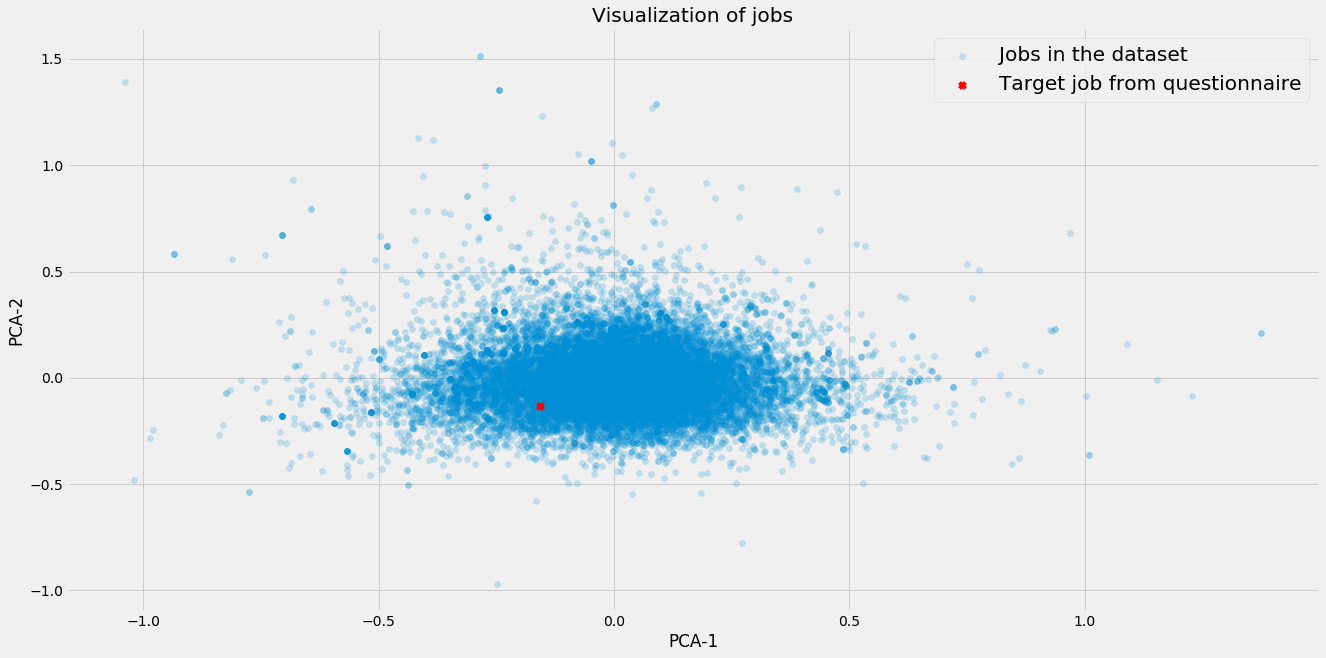

In [343]:
# calculate the average vector of the all the tokens
df['adj_word2vec_avg']=df['adj'].apply(vec_avg)

# re-arrange the list of vector - prepare for PCA data format
ls = []
for i, row in df.iterrows():
    vec = row.adj_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        ls.append(vec)

# build visualization by fitting a PCA model
pca = PCA(n_components=2)
pca.fit(ls)
X = pca.transform(ls)

# Let's look at the location of the job from the questionnaire.
adj_q = ['innovative','open','art','ai']
vec_q = vec_avg(adj_q).tolist()
X_q = pca.transform([vec_q])

# make the scatter plot
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X[:,0], X[:,1],alpha=0.2, label = 'Jobs in the dataset')
ax.scatter(X_q[:,0], X_q[:,1], c="r", marker='x', label = 'Target job from questionnaire')
ax.set(xlabel='PCA-1', ylabel='PCA-2', title='Visualization of jobs')
legend = ax.legend(loc='upper right', fontsize='x-large')

In [344]:
# the top20 cloest words in pre-trainned word2vec with the list from the questionnaire.
word2vec.most_similar(positive=[np.array(vec_q)], topn=20)

[('innovative', 0.6434879302978516),
 ('art', 0.6263483762741089),
 ('ai', 0.5634794235229492),
 ('cutting_edge', 0.5576755404472351),
 ('Safiya_Godlas', 0.5304438471794128),
 ('sculpture_printmaking', 0.5296679139137268),
 ('drawing_printmaking', 0.5282857418060303),
 ('Mary_GrandPre_Scholastic_FP', 0.5247808694839478),
 ('LSA_CC', 0.5227562189102173),
 ('cuttingedge', 0.5176814794540405),
 ('discovery_concept_ShockHound', 0.5168626308441162),
 ('photography_printmaking', 0.5130655169487),
 ('tools_meganucleases', 0.506268322467804),
 ('painting_sculpture_printmaking', 0.503749668598175),
 ('printmaking_sculpture', 0.5036592483520508),
 ('paintings_sculptures_photography', 0.5031106472015381),
 ('Lanky_brooding_Superman', 0.502635657787323),
 ('pottery_woodworking', 0.5024662613868713),
 ('Monotype_Imaging_combines', 0.5011813044548035),
 ('etchings_engravings', 0.5007979869842529)]

In [345]:
# calculate the closest job description in the dataset
# first create a list of tuples
ls_tuple = []
for i, row in df.iterrows():
    vec = row.adj_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        dis = distance.euclidean(vec, vec_q)
        ls_tuple.append((i, dis))

# find out the index of the minimun distance
index_min = 0
dis_min = 2
for t in ls_tuple:
    index, dis = t
    if dis < dis_min:
        dis_min = dis
        index_min = index
index_min

# the top1 job in the dataset that matches the keywords in my questionnaire.
df.job_description[index_min]

"In AT&T Labs we are always looking for new talent for Software Development in Overlay Networking and Cloud technologies. We envision and create cutting edge technologies that will revolutionize how networks and new services are architected, developed and managed. Our architects and engineers have a unique combination of access to real-world network, system and services, the ability to work with collaborators across the industry, opportunity to create the next generation network that will impact hundreds of millions of consumers and some of the largest corporations in the world. AT&T is currently embarking on a transformative initiative towards intelligent services by leveraging cloud technologies and Software Defined Networking (SDN). This modern architecture will simplify and scale AT&T’s network to help support the continued growth of Internet traffic, enable rapid deployment of an advanced cutting-edge features and services, provide industry leading security, performance and reliab

**The out put job is a Software development job, which is a cool job. However, I may have concerns that I do not have enough experience with this kind of software development job. Thus, the next section, industry, gives us another aspect of the job we are looking for**

## Nouns - industry

Given my key word: ['healthcare', 'programming', 'research', 'analysis'], those are the keywords describing the industry I'm interested in as well as the skills I have. 

/Users/yaqiongzhang/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning:

Mean of empty slice.



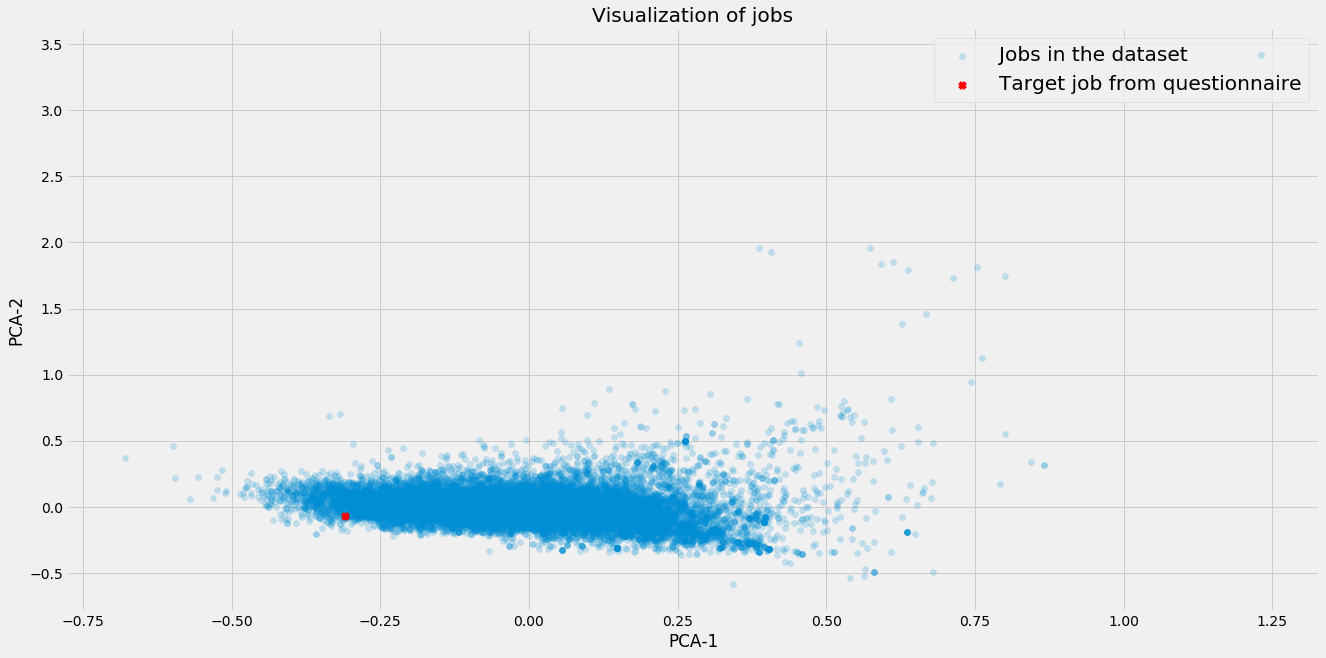

In [346]:
# calculate the average vector of the all the tokens
df['noun_word2vec_avg']=df['noun'].apply(vec_avg)

# re-arrange the list of vector - prepare for PCA data format
ls = []
for i, row in df.iterrows():
    vec = row.noun_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        ls.append(vec)

# build visualization by fitting a PCA model
pca = PCA(n_components=2)
pca.fit(ls)
X = pca.transform(ls)

# Let's look at the location of the job from the questionnaire.
noun_q = ['healthcare', 'programming', 'research', 'analysis']
vec_q = vec_avg(noun_q).tolist()
X_q = pca.transform([vec_q])

# make the scatter plot
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(X[:,0], X[:,1],alpha=0.2, label = 'Jobs in the dataset')
ax.scatter(X_q[:,0], X_q[:,1], c="r", marker='x', label = 'Target job from questionnaire')
ax.set(xlabel='PCA-1', ylabel='PCA-2', title='Visualization of jobs')
legend = ax.legend(loc='upper right', fontsize='x-large')

In [347]:
# the top20 cloest words in pre-trainned word2vec with the list from the questionnaire.
word2vec.most_similar(positive=[np.array(vec_q)], topn=20)

[('research', 0.7262023687362671),
 ('analysis', 0.6715405583381653),
 ('Predictive_modeling', 0.59686279296875),
 ('programming', 0.5733450651168823),
 ('Comparative_effectiveness', 0.5714759826660156),
 ('healthcare', 0.5607959032058716),
 ('Archimedes_Model', 0.5573633909225464),
 ('Strengths_Near', 0.5573630928993225),
 ('researchand', 0.5573137998580933),
 ('institute_ITRI', 0.5567862391471863),
 ('analyzes', 0.5556919574737549),
 ('www.DecisionResources.com', 0.5543057918548584),
 ('resarch', 0.547503650188446),
 ('DuPont_http://www.dupont.com', 0.5427551865577698),
 ('biochemical_profiling', 0.5423297882080078),
 ('interprofessional_education', 0.5420200228691101),
 ('SmithGeiger', 0.5420153737068176),
 ('StockPickReport.Com_ranks_stocks', 0.5419593453407288),
 ('Rigorous_scientific', 0.5412229299545288),
 ('Ronald_Gruia_principal', 0.5387206673622131)]

In [348]:
# calculate the closest job description in the dataset
# first create a list of tuples
ls_tuple = []
for i, row in df.iterrows():
    vec = row.noun_word2vec_avg.tolist()
    if len(str(vec)) > 3: # get rid of nan
        dis = distance.euclidean(vec, vec_q)
        ls_tuple.append((i, dis))

# find out the index of the minimun distance
index_min = 0
dis_min = 2
for t in ls_tuple:
    index, dis = t
    if dis < dis_min:
        dis_min = dis
        index_min = index
index_min

# the top1 job in the dataset that matches the keywords in my questionnaire.
df.job_description[index_min]

'\xa0 Posting Information \xa0 \xa0 \xa0 Open Date:\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 March 11, 2016 \xa0 \xa0 \xa0 Job Title:\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 Manager, Scientific \xa0 \xa0 \xa0 Division/Department:\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0 Xcenda, LLC \xa0 \xa0 \xa0 Job Type: \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 Full Time \xa0 \xa0# of Openings:\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0 1 \xa0Career Level:\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 See description below \xa0Education Required:\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 Please refer to job description \xa0Categor

**From the above analysis, the program gives me a job that is healthcare statistical programmer. I think it does matches what I'm interested in.**

# Combine all the factors together:

Let's say: 
- Location factor 20%
- Industry factor 40%
- Culture factor 40%

And we will calculate the most related job by using these weights. Location factor is a little bit tricky, since it's not in a vector format as the other factors.


In [ ]:
/ Other embedding emthod

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(ls_X) 
X_embedded.shape

In [ ]:
# bag_of_word method
# from gensim Quickstart

bow_corpus = [dictionary.doc2bow(text) for text in df_adj_ls]
bow_corpus

In [ ]:
# tf-idf modle
from gensim import models
# train the model
tfidf = models.TfidfModel(bow_corpus)
# transform the "system minors" string
xy = tfidf[dictionary.doc2bow("flexible art big local".lower().split())]

In [ ]:
x = [x[0] for x in xy]
y = [x[1] for x in xy]

In [ ]:
plt.scatter(x,y);